## Семинар 14. Нелинейная регрессия.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

### Задача №1

В файле "BostonData.txt" представлены данные о домах в пригородах Бостона, в том числе такие характеристики как:

medv – средняя стоимость домов

lstat – процент владельцев с низким социальным статусом

rm – среднее количество комнат в доме

age – возраст домов

crim – показатель криминальности района


Охарактеризовать линейную зависимость средней стоимости домов от процента владельцев с низким социальным статусом (подобрать степень полиномиальной регрессии).

In [3]:
data = pd.read_csv('BostonData.txt') 
y = data['medv']
x_1 = data['lstat'] # первая степень

In [4]:
x_1_train, x_1_test, y_train, y_test = train_test_split(x_1, y, test_size=0.25, random_state=10)

In [5]:
# Считаем среднее значение кросс-валидации на полиномиальной регрессии,
# построенной на степенях от 1 до k
def calc_kfold_validation(k, x, y):
    x_k = x[['factor{}'.format(i) for i in range(1, k+1)]]
    lr = LinearRegression()
    cv_scores = cross_val_score(lr, x_k, y, cv=5, scoring="neg_mean_squared_error")
    return np.mean(-cv_scores)

In [6]:
def best_degree (max_degree, x_1, y):
    # max_degree - максимальная степень, до которой будем искать полином
    x = x_1.rename('factor1').to_frame() # делаем датафрейм
    for k in range(2, max_degree+1): 
        x['factor{}'.format(k)] = np.power(x['factor1'], k) #добавляем в x столбцы различных степеней factor
    res = pd.Series(index=range(1, max_degree + 1))
    for k in res.index.values:
        res.loc[k] = calc_kfold_validation(k, x, y)
    res.plot(marker='o')
    return res.idxmin() #индекс, на котором достигается min, так как MSE

/home/andrew/miniconda3/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


3

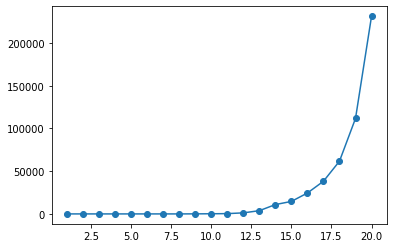

In [7]:
best_degree(20, x_1_train, y_train)

/home/andrew/miniconda3/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


3

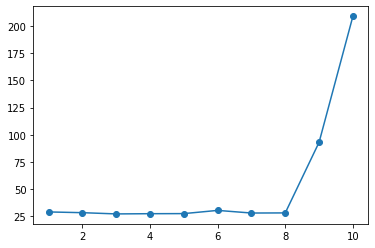

In [8]:
best_degree(10, x_1_train, y_train)

### Ramsey RESET test

"The test fits an auxiliary OLS regression where the design matrix, exog,
    is augmented by powers 2 to degree of the fitted values. Then it performs
    an F-test whether these additional terms are significant.

    If the p-value of the f-test is below a threshold, e.g. 0.1, then this
    indicates that there might be additional non-linear effects in the model
    and that the linear model is mis-specified."

In [9]:
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

Хотелось бы сделать так...

In [10]:
x_1_train_plus_c = add_constant(x_1_train)
ols = OLS(y_train, x_1_train_plus_c)
results = ols.fit()

In [11]:
reset_ramsey(results, degree = 3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[15.76528782]]), p=2.6661519371384307e-07, df_denom=375, df_num=2>

Но! Для данного теста нужна нормальность остатков (которой нет).

Плюс важно еще помнить о том, что данный тест может отвергать нулевую гипотезу из-за того, что в **исходной модели пропущена существенная переменная**, влияние которой **частично учтено введением нелинейных членов**.

Для сравнения, если рассмотреть зависимость от всех признаков (в такой модели нормальность остатков не будет отвергаться, это можно отдельно проверить):

In [12]:
x_full = add_constant(data.drop(['medv'], 1))
x_full_train, x_full_test, y_train, y_test = train_test_split(x_full, y, test_size=0.25, random_state=10)
ols = OLS(y_train, x_full_train)
results = ols.fit()
reset_ramsey(results, degree = 3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.24093494]]), p=0.7860183292941287, df_denom=363, df_num=2>